# MNIST 

The MNIST dataset contains 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents. 

This notebook is following Chapter 3 of Hands-on Machine Learning (notebook). 

In [ ]:
# Get the data 
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Datasets loaded by Scikit-Learn generally have a similar dictionary structure:

- A DESCR key describing the dataset 

- A data key with one row per instance and one column per feature

- A target key containing an array w/ the labels

In [ ]:
# Look at the data 
X, y = mnist['data'], mnist['target']
X.shape, y.shape

((70000, 784), (70000,))

There are 70,000 images, each with 784 features. Each image is 28x28 pixels, and each feature represents one pixel's intensity from 0 (white) to 255 (black). 

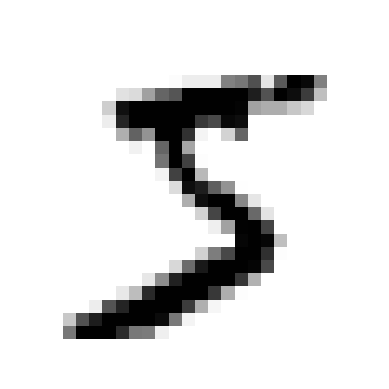

In [ ]:
# Examine a single instance 
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [ ]:
# Confirm 
y[0]

'5'

In [ ]:
# Cast y to integer instead of string
y = y.astype(int)
y[0]

5

In [ ]:
# Create a test set and put it aside 
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Note that the dataset is already split intro training (first 60,000 rows) and test (last 10,000 rows) sets. In addition, the training set is already shuffled for us, meaning all cross-validation folds will be similar (no folds will be missing a digit). In addition, some learning algorithms are sensitive to the order of instances, and will perform poorly if they get too many similar instances in a row. 

# Train a binary classifier 

Let's simplify the problem and create a model to predict just a single digit. For now, let's use the number 5. 

In [ ]:
# Create true/false labels for 5 
y_train_5 = (y_train == 5) # True for all 5s, false for all other digits 
y_test_5 = (y_test == 5)

We can start with a Stochastic Gradient Descent (SGD) classifier. It handles large datasets very efficiently, in part because it handles training instances independently, one at a time.  

In [ ]:
from sklearn.linear_model import SGDClassifier
import joblib
import os 

os.makedirs('models', exist_ok=True)

# sgd_clf = SGDClassifier(random_state=42)
# sgd_clf.fit(X_train, y_train_5)

# joblib.dump(sgd_clf, 'models/sgd_clf.joblib')
sgd_clf = joblib.load('models/sgd_clf.joblib')

SGD relies on randomness during training, hence the name stochastic. To get reproducible results, set the random_state parameter. 

In [ ]:
sgd_clf.predict([some_digit])

array([ True])

The model predicts True for this instance, and it is correct because some_digit is indeed a 5. 

# Performance measures

Evaluating a classifier is often trickier than evaluating a regressor. 

## Accuracy (using cross-validation)

In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np

os.makedirs('arrays', exist_ok=True)

# cross_val_score_sgd_clf = cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')
# np.save('arrays/cross_val_score_sgd_clf.npy', cross_val_score_sgd_clf)
cross_val_score_sgd_clf = np.load('arrays/cross_val_score_sgd_clf.npy')
cross_val_score_sgd_clf

array([0.95035, 0.96035, 0.9604 ])

~95% prediction accuracy on each fold does look amazing, but let's compare it to a "dumb" classifier that just predicts False for each instance (not-5). 

In [ ]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass

    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

With our "dumb" classifier, we achieved over 90% accuracy for all folds. Only about 10% of the dataset is 5s, meaning that if you always predict that an image is not a 5, you will be correct 90% of the time. This highlights why accuracy is not a great performance measure for classification tasks, especially when you're dealing with skewed datasets (some classes are much more frequent than others). 

## Confusion matrix 

To compute a confusion matrix, you first need a set of predictions so they can be compared to the actual targets. Let's use cross_val_predict on our training data. Instead of just returning our evaluation score for each fold, it also returns the predictions. These are considered "clean" predictions, because the prediction is made on an instance (in the test fold) by a model that never saw that data during training (because it only use the training folds). 

In [ ]:
from sklearn.model_selection import cross_val_predict

# y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
# np.save('arrays/cross_val_predict_sgd_clf.npy', y_train_pred)
y_train_pred = np.load('arrays/cross_val_predict_sgd_clf.npy')
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

Each row in a confusion matrix represents an actual class, and each column represents a predicted class. The first row considers non-5 images (the negative class), and the second row considers images of 5s (the positive class).  

- True negative (top left): non-5 images correctly classified as non-5s

- False positive (top right): non-5 images incorrectly classified as 5s

- False negative (bottom left): 5 images incorrectly classified as non-5s

- True positive (bottom right): 5 images correctly classified as 5s 

A couple more concise metrics to summarize the information from the confusion matrix: 

- precision = TP / (TP +FP)

- recall = TP / (TP + FN)

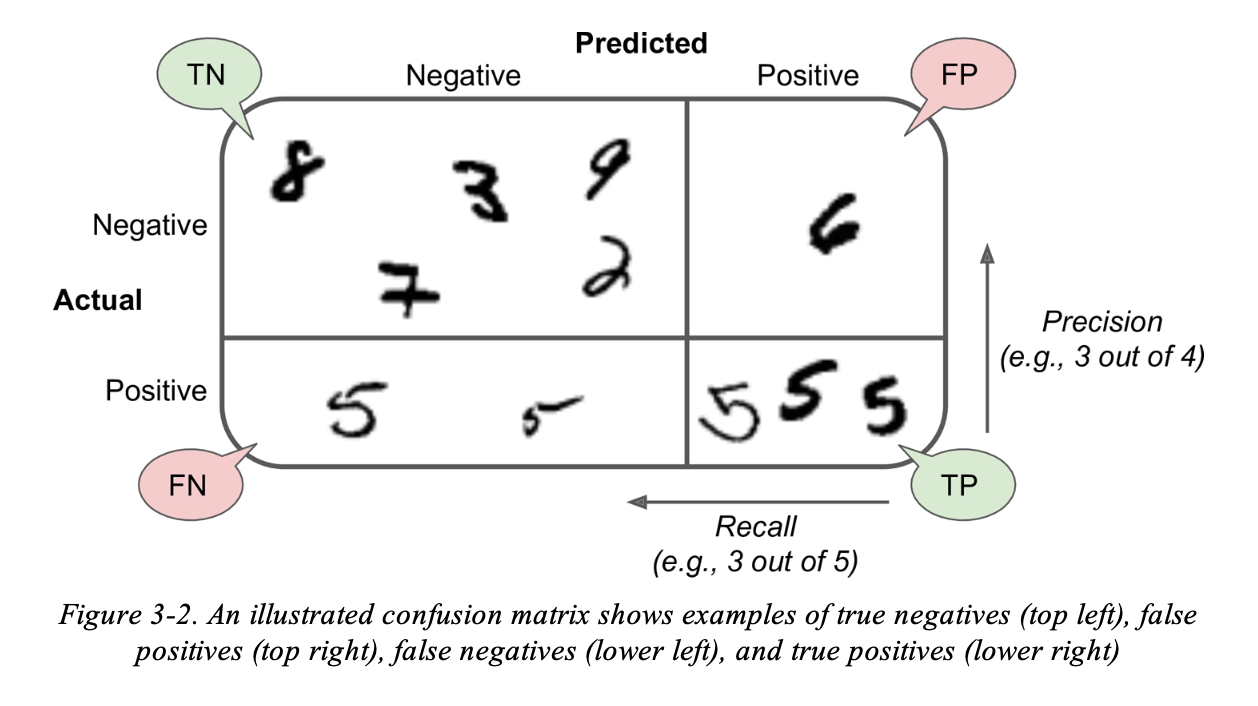

In [ ]:
import IPython.display as display
os.makedirs('figures', exist_ok=True)

display.Image('figures/confusion_matrix.png')

## Precision and recall

In [ ]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [ ]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

Now our SGD classifier doesn't look so great. When it claims an image is a 5, it's only correct 83% of the time (precision). Moreover, it only detects 65% of the 5s (recall). 

We can combine precision and recall into a single metric called the F1 score. This is especially helpful if we need to compare two classifiers. 

- F1 score is the harmonic mean of precision and recall. Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values. So the F1 score will only be high if both recall and precision are high. 

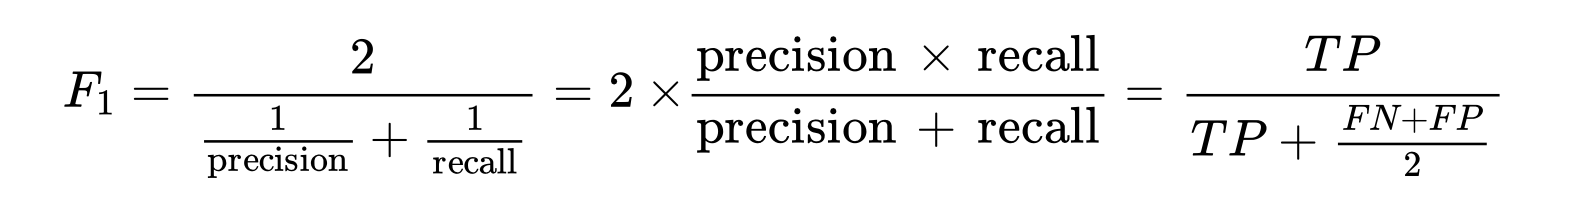

In [ ]:
display.Image('figures/f1_score.png')

## Precision/recall trade-off

The F1 score favors classifiers that have similar precision and recall, but this is not always want. Some contexts you mostly care about precision, and in other contexts you really care about recall. 

- E.g. training a classifier to detects videos that are safe for kids. You probably prefer a classifier that rejects many good videos (low recall), but keeps only safe ones (high precision). 

You can't have it both ways: increasing precision reduces recall, and vice versa. This is called the precision/recall trade-off. 

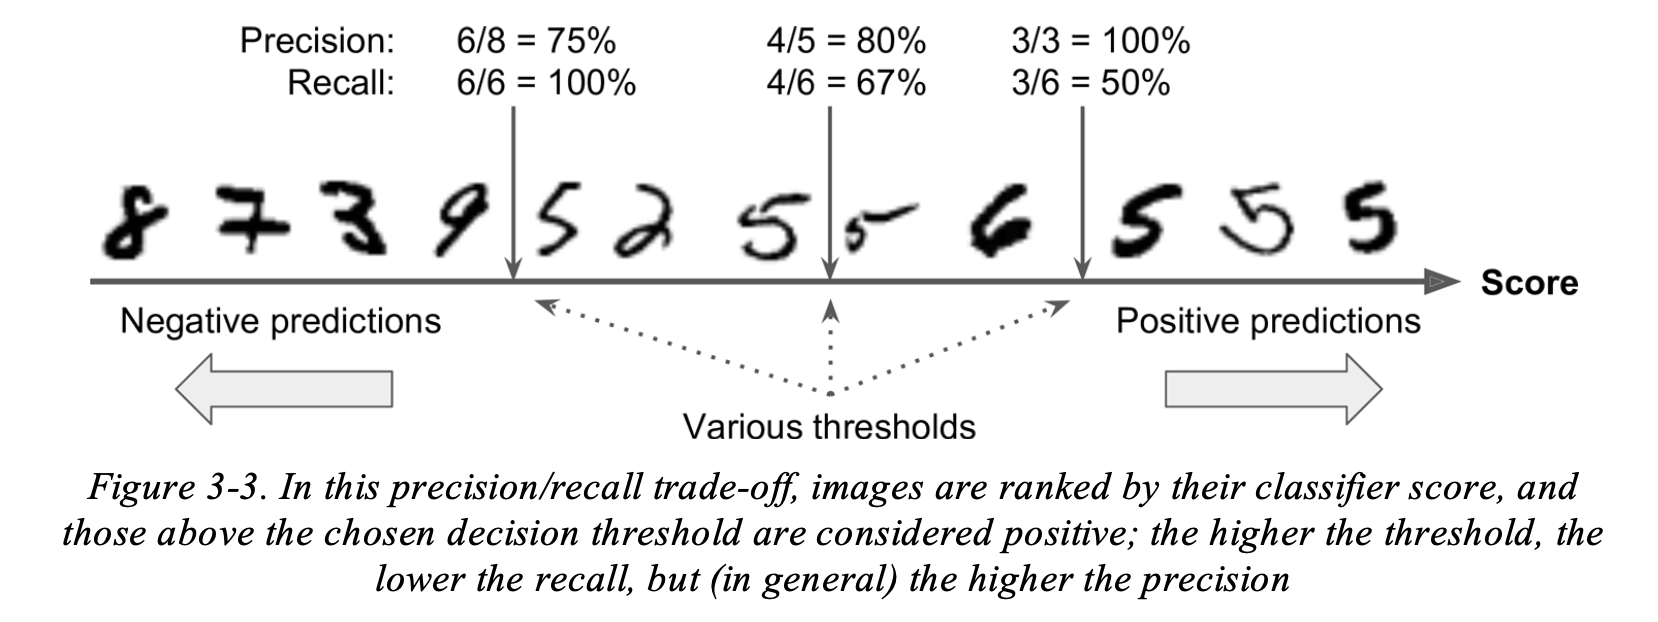

In [ ]:
display.Image('figures/precision_recall_tradeoff.png')

There is a threshold used by SGDClassifier algorithms to determine which class to assign to. Each instance gets a score computed by a decision function. If score > threshold, that instance is assigned to the positive class (and vice versa). 

While you can't set the threshold directly, you can see the score assigned to each instance and then use any threshold you want to make predictions based on those scores: 

In [ ]:
y_scores = sgd_clf.decision_function([some_digit]) # Remember, some_digit is actually a 5 instance 
y_scores

array([2164.22030239])

In [ ]:
# Using the score from some_digit as a threshold 
threshold = 0 
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

SGDClassifier uses a threshold equal to 0, so the above code returns the same result as predict(). 

In [ ]:
# Raising the threshold 
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

Raising the threshold does indeed decrease recall. The image is actually a 5. When the threshold is 0 it correctly predicts True, but when we raise the threshold it incorrectly predicts False. We can use cross_val_predict() to get decision scores for each instance. 

In [ ]:
# y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')
# np.save('arrays/cross_val_predict_scores_sgd_clf.npy', y_scores)
y_scores = np.load('arrays/cross_val_predict_scores_sgd_clf.npy')
y_scores[0]

1200.930512369027

In [ ]:
# Compute precision and recall for all possible thresholds
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

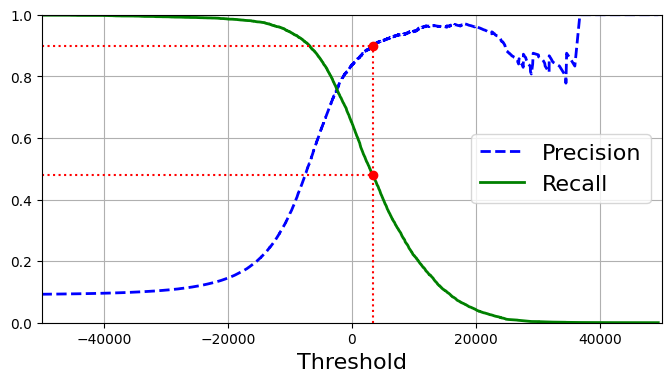

In [ ]:
# Plot precision and recall as functions of threshold value 
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision', linewidth=2)
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall', linewidth=2)
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([-50000, 50000, 0, 1])

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 4))                                                                  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             
plt.show()

Note how the precision curve is bumpier than the recall curve. Precision may sometimes go down when you raise the threshold (although in general it will go up). However, recall can only go down when you increase the threshold. 

We can also plot precision directly against recall as another way to select a good precision/recall trade-off. 

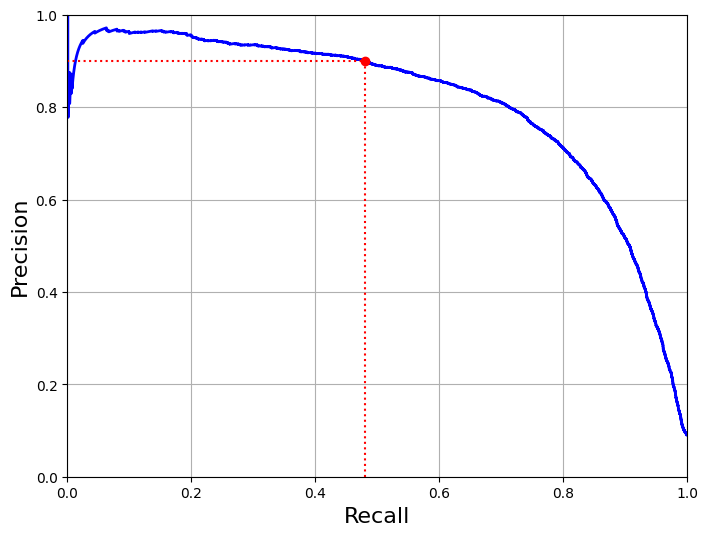

In [ ]:
# Plot precision directly against recall 
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

Precision here really falls off around 80% recall. You probably want to select a precision/recall trade-off just before that drop (e.g. 60% recall), but it depends on your project. 

In [ ]:
# Aiming for 90% precision 
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

# Make predictions using this threshold 
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [ ]:
# Check precision and recall 
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [ ]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

It's fairly easy to create a classifier with virtually any precision you want, just set a high enough threshold. Remember that the higher your precision, the lower your recall is! If someone says, "let's reach 99% precision", you should ask, "at what recall?"

## The ROC curve 

The receiver operating characteristic (ROC) curve is another common tool for binary classifiers. It's similar to the precision/recall curve, but instead it plots the true positive rate (aka recall) against the false positive rate (FPR), or the ratio of negative instances that are incorrectly classified as positive. FPR is equal to 1 - true negative rate (TNR), which is the ratio of negative instances that are correctly classified as negative. TNR is also called specificity. 

- Recall is also known as sensitivity. 

- ROC curve plots sensitivity vs. 1 - specificity

Once again there is a trade-off: the higher the recall (TPR), the more false positives (FPR) the classifier producers. 

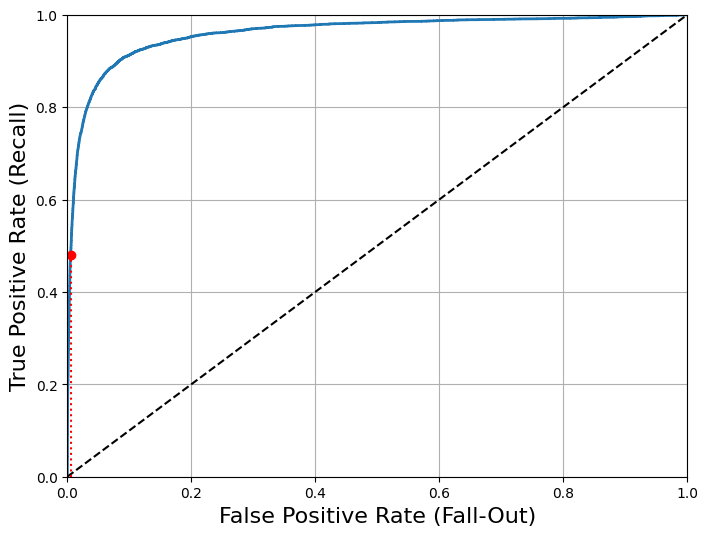

In [ ]:
# Plot the ROC curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                                    
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  
plt.plot([fpr_90], [recall_90_precision], "ro")               
plt.show()

The dotted line represents the ROC curve of a purely random classifier. A good classifier stays as far away from that line as possible (towards the top-left corner). 

We've plotted the FPR against the TPR for all possible thresholds. The red circle is our chosen ratio with 90% precision (47% recall). 

We can compare classifiers by measuring the area under the curve (AUC). A perfect classifier will have ROC AUC equal to 1, whereas a purely random one will have a ROC AUC equal to 0.5. 

In [ ]:
# Get ROC AUC score 
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

How to choose between ROC curve and precision/recall (PR) curve::

- You should prefer PR curve whenever the positive class is rare or when you care more about false positives than the false negatives. 

- Otherwise, use the ROC curve. 

Other descriptions not from book: 

- Imbalanced class distribution --> use PR. They provide better understanding of the trade-off between precision and recall for imbalanced datasets. 

- Focus on positive class --> use PR. If you're more concerned with performance of positive class (e.g. medical diagnoses or fraud detection), PR curve is more suitable. 

- Specific performance goals --> use ROC. If you have specific goals in terms of True Positive Rate or False Positive Rate, ROC curve is more appropriate. 

- Comparing models/algorithms --> use ROC. If you want to compare performance of multiple models or algorithms, ROC curves can provide more general overview and facilitate easy comparison (ROC AUC). 

Let's train a Random Forest model and compare it's ROC curve and ROC AUC score to that of the SGDClassifier. 

- RandomForestClassifier does not have a decision_function method, so we'll predict_proba. This returns a probability (between 0 and 1) whether the given instance represents a class (one row per instance, one column per class). 

In [ ]:
# Train a random forest model 
from sklearn.ensemble import RandomForestClassifier

# forest_clf = RandomForestClassifier(random_state=42)
# y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba') 
# np.save('arrays/cross_val_predict_proba_forest_clf.npy', y_probas_forest)
y_probas_forest = np.load('arrays/cross_val_predict_proba_forest_clf.npy')

roc_curve expects labels and scores, but we don't have scores from our random forest model. Rather, we have probabilities. We can feed roc_curve these probabilities instead. 

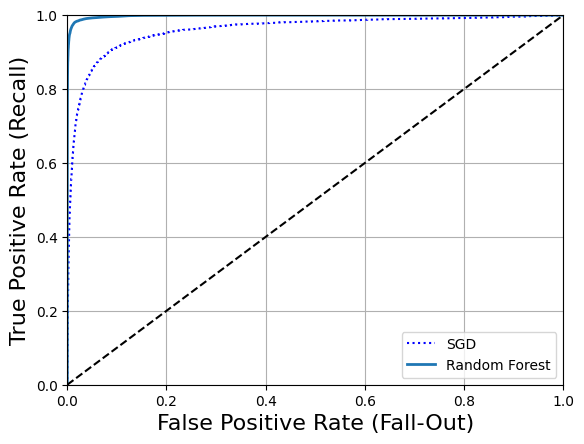

In [ ]:
# Plot ROC curve 
y_scores_forest = y_probas_forest[:, 1] # score = probability of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')

plt.legend(loc='lower right')
plt.show()

Clearly the Random Forest model is superior to our stochastic model, as its ROC curve comes much closer to the top left corner (hence, its ROC AUC score should be higher). 

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [ ]:
# Generate recall and precision scores for Random Forest model 

# y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
# np.save('arrays/cross_val_predict_forest_clf.npy', y_train_pred_forest)
y_train_pred_forest = np.load('arrays/cross_val_predict_forest_clf.npy')
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [ ]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

99% precision and 86% recall! This is better than the our earlier stochastic model, which had 84% precision and 65% recall. 

# Multiclass classification

Also known as multinomial classifiers, they can distinguish between more than two classes. 

Some can handle multiple classes natively (e.g. SGD, Random Forest, naive Bayes), while others are strictly binary classifiers (e.g. Logistic Regression, Support Vector Machines). There are strategies you can use to implement multiclass classification with these binary classifiers, however. 

- For example, to classify digits in 10 classes (0 through 9), you can create 10 separate binary classifiers, one for each digit (a 0-detector, 1-detector, 2-detector, and so on). Then when you want to classify an image, you get a decision score from each classifier and select the class whose classifier outputs the highest score. This is called the one-versus-the-rest (OvR) strategy, also known as one-versus-all. 

- Alternatively, you can create a classifier for every pair of digits: one to distinguish between 0s and 1s, another for 0s and 2s, another for 1s and 2s, and so on. This is the one-versus-one strategy (OvO). If there are N classes, you need to train N x (N - 1) / 2 classifiers. For the MNIST problem, that means 45 classifiers. When you want to classify an image, you need to run it through all 45 classifiers and see which class wins the most duels. The advantage of an OvO strategy is that for each classifier, it only needs to be trained on part of the training set for the two classes it must distinguish. 

SVM classifiers scale poorly with larger training datasets, so OvO is preferred since it's faster to train many classifiers on smaller training sets than a few on larger training sets. Otherwise, OvR is preferred. 

In [ ]:
# Scikit-Learn automatically runs OvR or OvO depending on the algorithm 
from sklearn.svm import SVC 

svm_clf = SVC()
# svm_clf.fit(X_train, y_train)
# joblib.dump(svm_clf, 'models/svm_clf.joblib')
svm_clf = joblib.load('models/svm_clf.joblib')
svm_clf.predict([some_digit]) # Remember, this digit is a 5 

array([5])

Under the hood, Scikit-Learn is running OvO (45 separate models) for this SVM model. 

In [ ]:
# If you call decision_function(), it returns 10 scores per instance 
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [ ]:
np.argmax(some_digit_scores)

5

In [ ]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
svm_clf.classes_[5]

5

When a classifier is trained, it stores the list of target classes in its classes_ attribute, ordered by value. In this case, the index of each class conveniently matches the class itself. Normally that won't be the case. 

In [ ]:
# You can force Scikit-Learn to use either OvR or OvO 
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
# ovr_clf.fit(X_train, y_train)
# joblib.dump(ovr_clf, 'models/ovr_clf.joblib')
ovr_clf = joblib.load('models/ovr_clf.joblib')
ovr_clf.predict([some_digit])

array([5])

In comparison, training an SGDClassifier or RandomForestClassifier is a bit simpler, since these models can natively classify instances into multiple classes without the use of OvR or OvO strategies. 

In [ ]:
sgd_clf_full = SGDClassifier() # We already have an SGDClassifier for only 5s
# sgd_clf_full.fit(X_train, y_train)
# joblib.dump(sgd_clf_full, 'models/sgd_clf_full.joblib')
sgd_clf_full = joblib.load('models/sgd_clf_full.joblib')
sgd_clf_full.predict([some_digit])

array([5])

In [ ]:
sgd_clf_full.decision_function([some_digit])

array([[-16249.68595976, -25479.89949928, -10766.13910768,
          -446.88395847, -15669.03793837,   4828.12507045,
        -23397.9338514 , -18446.2605343 ,  -8484.3357045 ,
         -8880.28413458]])

As expected, there are 10 decision scores returned, one for each class. the SGD model is fairly confident that this is a 5. Notice how all the scores are negative except for class 5. 

In [ ]:
# Evaluate using cross-validation 
# cross_val_score_sgd_clf_full = cross_val_score(sgd_clf_full, X_train, y_train, cv=3, scoring='accuracy')
# np.save('arrays/cross_val_score_sgd_clf_full.npy', cross_val_score_sgd_clf_full)
cross_val_score_sgd_clf_full = np.load('arrays/cross_val_score_sgd_clf_full.npy')
cross_val_score_sgd_clf_full

array([0.88195, 0.87745, 0.86855])

We get over 87% on all test folds. A completely random classifier would get 10% accuracy. Not too bad. 

For future reference: explaining difference between fit() and cross_val_score() for model training and evaluation purposes

In [ ]:
# Try to improve scores using scaled data 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(float))
# cross_val_score_sgd_clf_full_scaled = cross_val_score(sgd_clf_full, X_train_scaled, y_train, cv=3, scoring='accuracy')
# np.save('arrays/cross_val_score_sgd_clf_full_scaled.npy', cross_val_score_sgd_clf_full_scaled)
cross_val_score_sgd_clf_full_scaled = np.load('arrays/cross_val_score_sgd_clf_full_scaled.npy')
cross_val_score_sgd_clf_full_scaled

array([0.90175, 0.89385, 0.9071 ])

# Error analysis

Once you find a promising model, you want to find ways to improve it. One way to do this is to analyze the types of errors it makes, which can be accomplished using a confusion matrix. 

In [ ]:
# Make predictions and get confusion matrix 
# y_train_pred = cross_val_predict(sgd_clf_full, X_train_scaled, y_train, cv=3)
# np.save('arrays/cross_val_predict_sgd_clf_full_scaled.npy', y_train_pred)
y_train_pred = np.load('arrays/cross_val_predict_sgd_clf_full_scaled.npy')
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5597,    0,   26,    7,    9,   52,   37,    6,  188,    1],
       [   1, 6408,   42,   25,    4,   46,    4,    8,  189,   15],
       [  29,   27, 5273,   98,   73,   28,   67,   41,  312,   10],
       [  27,   17,  122, 5273,    2,  215,   27,   42,  334,   72],
       [  12,   15,   54,   13, 5218,   11,   39,   25,  279,  176],
       [  30,   16,   38,  175,   53, 4525,   75,   16,  430,   63],
       [  29,   16,   47,    3,   41,   99, 5570,    3,  109,    1],
       [  22,   10,   57,   31,   50,   14,    3, 5715,  144,  219],
       [  21,   65,   47,   93,    3,  133,   28,   11, 5402,   48],
       [  26,   21,   32,   68,  117,   37,    1,  181,  297, 5169]])

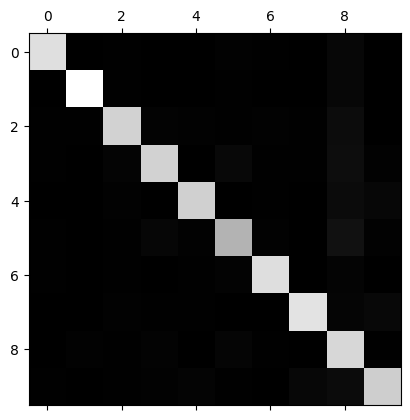

In [ ]:
# Display confusion matrix a bit more simply using matshow()
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

This confusion matrix looks pretty good, since most images are on the main diagonal, meaning they were classified correctly. The 5s look slightly darker, which means either there are fewer 5s in the dataset entirely or the classifier does not perform as well. 

Let's focus the plot on the errors. Divide each value in the confusion matrix by the number of images in the corresponding class to compare error rates instead of absolute numbers of errors.

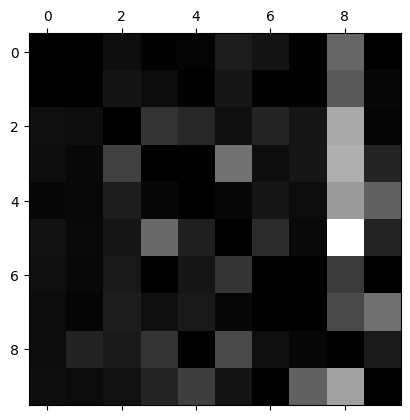

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

# Fill diagonal with zeros to keep only errors 
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

We can see very clearly the types of errors the classifier makes. Remember, rows are the actual class, and columns are the predicted class. 

The column for class 8 is very bright, meaning many images get misclassified as 8s. 3s and 5s also seem to get confused with one another, in both directions. 

- Your efforts should be spent on reducing the false 8s. This could involve gathering more training data for digits that look like 8s (but are not) so that the classifier can learn to distinguish them from real 8s. 

- Or engineer new features to help the classifier. E.g. an algorithm 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=bc863753-6658-49cb-8c7f-21a2f854fc68' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>